## Controle Quântico Ótimo - Utilização do CG para ajuste do caminho percorrido por uma partícula

Nessa etapa, é necessário avaliar, a partir da equação de Schrödinger com os kets, com o método de Runge-Kutta e com o controle MPC, como a curva de origem ajusta-se a curva de destino. Além disso, é interessantíssimo a avaliação a partir do estado estacionário e ainda verificar como ocorre o ajuste de fases.

Para analisar como o controle melhora o condicionamento da curva através da sua análise futura, esse arquivo estará analisando os ajustes no horizonte 3 ao 10. Para melhor coerência dos resultados, a otimização será utilizada para substituir na variável independente da função objetivo e ainda será normalizada para que as comparações tenham o mesmo peso.

Nesse projeto usa-se o gradiente devido a sua facilidade de reprodução, vide os projetos fora da biblioteca do python, além dos problemas do cálculo da Hessiana na otimização não linear utilizando o método de Newton e suas variantes.

Para uma aproximação ótima, utiliza-se um passo de integração (fator do Runge Kutta) com o valor de 0.01, prevendo um milésimo a frente, mas para uma aplicação real a intenção é o aumento dessa fator para uma produção mais real.

In [1]:
# Bilbiotecas para auxílio na programação matemática
import math, sys 
import numpy as np
import sympy as sp

from scipy import sparse # Produção das diagonais das matrizes
from scipy.sparse import diags 

# Plotagem 2D e 3D
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm


from os import path # Suficiente para manipulação de arquivos
    
# Para solução exata
from scipy.special import hermite
from math import factorial

%matplotlib inline
count = 0

# Para otimização dos sistemas
from scipy import optimize

import random

Abaixo se dão os requisitos básicos para a instauração do teste. Se tem formas de subtrair e somar matrizes, a manipulação das derivadas com o Runge-Kutta além da própria proposta da função objetivo.

In [2]:
# Manipulação das matrizes

def somar(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] + B[i][j]

    return C

def sub(A, B):
    C = []
    nLinhasA, nLinhasB = len(A), len(B)
    nColA, nColB = len(A[0]), len(B[0])
    
    for i in range (nLinhasA):
        linha = [0]*nColA
        C.append(linha)
        for j in range(nColA):
            C[i][j] = A[i][j] - B[i][j]

    return C


#################################################################

## d (psi) / dt = -i * H * |psi>
def dpsidt(t, psi, H): # A derivada da onda em relação ao tempo não tem dependência temporal
    A = np.zeros((2,2), dtype=np.complex_)
    A = np.dot(complex(0,1),H) # i * H
    return -1*np.matmul(A,psi) # - i * H * |psi>

# Runge-Kutta de quarta ordem

def rungeKutta(onda, fatorRungeKutta, hamiltoniano, tempoFinal = 2, tempoInicial = 0):
    
    resultado = np.zeros((2,2), dtype=np.complex_)
    indice = 0

    for i in range(0, 2):
        
        resultado[0][indice] = onda[0][0]
        resultado[1][indice] = onda[1][0]
        
        k1 = dpsidt(tempoInicial, onda, hamiltoniano)
        k2 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k1)), hamiltoniano)
        k3 = dpsidt(tempoInicial + 0.5 * fatorRungeKutta, somar(onda, np.dot((0.5*fatorRungeKutta), k2)), hamiltoniano)
        k4 = dpsidt(tempoInicial + fatorRungeKutta, somar(onda, np.dot(fatorRungeKutta, k3)), hamiltoniano)
        
        ## y(i+1) = y(i) + h/6*(k1+2*k2+2*k3+k4)
        
        A = somar(np.dot(2,k3), k4)
        B = somar(np.dot(2,k2), k1)
        C = somar(A, B)
 
        onda = somar(onda,np.dot((fatorRungeKutta / 6.0),(C)))
    
        tempoInicial += fatorRungeKutta
        
        indice += 1
        
    runge = np.zeros((2,1), dtype=np.complex_)
    runge[0][0] = resultado[0][indice-1]
    runge[1][0] = resultado[1][indice-1]
    return runge

def funcaoObjetivo(x, iteracao, ondaDestino, hamiltoniano, onda, horizonteAnalisavel, fatorRungeKutta, tempoAnalise):
    
    avanco = np.zeros((2,1),dtype=np.complex_)
    
    y = 0
    
    horizonte = (horizonteAnalisavel+iteracao)/100
    
    tempo = iteracao/100
    
    tempoInicialAnalise = 0.00
    tempoFinalAnalise = 0.02
    
    controles = np.zeros((2,2), dtype=np.complex_)
    controles = [[0, x[0]], [x[0], 0]]
    
    matrizOrigem = np.zeros((2,1),dtype=np.complex_)
    matrizOrigem = [[onda[0][0]], [onda[1][0]]] 

    matrizDestino = np.zeros((2,1),dtype=np.complex_)
    
    ## Função-Objetivo (Return) = somatorio ||(Matriz_Origem - Matriz_Destino)||^2
    
    ## Avanço temporal
    
    matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
    matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)

    y += (np.linalg.norm(matrizOrigem-matrizDestino))**2

    avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

    matrizOrigem = avanco

    tempoInicialAnalise += 0.01
    tempoFinalAnalise += 0.01
    
    for indice in range((iteracao+1), (horizonteAnalisavel+iteracao)):
        tempo = indice/100
        
        matrizDestino[0][0] = ondaDestino[0][0]*np.exp(-1*complex(0,1)*(1/2*np.pi)*tempo)
        matrizDestino[1][0] = ondaDestino[1][0]*np.exp(-1*complex(0,1)*(3/2*np.pi)*tempo)
        
        y += (np.linalg.norm(matrizOrigem-matrizDestino))**2
        
        controles = [[0, x[int(tempoInicialAnalise*100)]], [x[int(tempoInicialAnalise*100)], 0]]

        avanco = rungeKutta(matrizOrigem, fatorRungeKutta, somar(hamiltoniano, controles), tempoFinal = tempoFinalAnalise, tempoInicial = tempoInicialAnalise)

        matrizOrigem = avanco

        tempoInicialAnalise += 0.01
        tempoFinalAnalise += 0.01
    
    return y

Para o funcionamento do MPC, cria-se um looping que consiste em uma otimização não linear, com o apoio da biblioteca de otimização do pyhton, de forma a obter o melhor resultado para o ajuste da curva. Com esse valor em mãos, utiliza-se para os pontos da próxima iteração do método de controle além de efetivar o ajuste realizando o Runge-Kutta com o valor otimizado.

In [3]:
## Constantes

horizonte = 3
fatorRungeKutta = 0.01 # Passo de Integração

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos3 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda3 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo3 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/np.sqrt(2)), (1/np.sqrt(2))], [(1/np.sqrt(2)), -(1/np.sqrt(2))]]

iteracao = 0
tempoAnalise = 2000

tempoInicial = 0
tempoFinal = 0

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda3[0][iteracao] = ondaOrigem[0][0]
    valoresOnda3[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes3[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes3[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos3[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo3[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo3[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = tempoFinal, tempoInicial = tempoInicial)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    tempoInicial += 0.01
    tempoFinal += 0.01
    
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[0])
    
    iteracao += 1

In [4]:
## Constantes

horizonte = 10
fatorRungeKutta = 0.01

## Chute inicial

x = []
x.append(random.uniform(-1, 1))
for l in range(1, horizonte):
    x.append(x[0])

# Função de origem e destino

ondaOrigem = [[complex(0.80,0.0)],[complex(0.60,0.0)]]
ondaDestino = [[complex(1/np.sqrt(2),0.0)],[complex(1/np.sqrt(2),0.0)]]

# Análise das respostas

minimos10 = np.zeros((1,2000), dtype=np.complex_) # Verificar se o mínimo será zero
constantes10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar se as integrais estão resultando em 1
valoresOnda10 = np.zeros((2, 2000), dtype=np.complex_) # Para verificar as componentes de cada onda
valoresFuncaoObjetivo10 = np.zeros((1,2000), dtype=np.complex_) # Conferir se o mínimo está realmente ajustado

# Hamiltoniano

hamiltoniano = np.zeros((2,2), dtype=np.complex_) 
hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]

iteracao = 0
tempoAnalise = 2000

while iteracao < tempoAnalise:
    
    #print(f"Iteração: {iteracao+1}")
    
    # Variação do Psi
    valoresOnda10[0][iteracao] = ondaOrigem[0][0]
    valoresOnda10[1][iteracao] = ondaOrigem[1][0]
    
    # Obtenção das constantes que multiplicam Psi
    constantes10[0][iteracao] = ondaOrigem[0][0] / np.exp(-1*complex(0,1)*(1/2*np.pi)*iteracao/100)
    constantes10[1][iteracao] = ondaOrigem[1][0] / np.exp(-3*complex(0,1)*(1/2*np.pi)*iteracao/100)
        
    ## Minimização
    
    resultado = optimize.minimize(funcaoObjetivo, x, args=(iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise), method='CG')

    #print(f"Mínimo: {resultado.x}")
    
    # Função objetivo
    
    minimos10[0][iteracao] = resultado.x[0]
    
    valoresFuncaoObjetivo10[0][iteracao] = funcaoObjetivo(resultado.x, iteracao, ondaDestino, hamiltoniano, ondaOrigem, horizonte, fatorRungeKutta, tempoAnalise)
    
    #print(f" Conferindo: {valoresFuncaoObjetivo10[0][iteracao]}")
    
    ## Hamiltoniano corntrolado
    
    controle = np.zeros((2,1), dtype=np.complex_)
    controle = [[0, resultado.x[0]],[resultado.x[0], 0]]
    hamiltoniano = somar(hamiltoniano, controle)
    
    ## Adaptação da onda ao controle
    
    ondaAvancada = np.zeros((2,2), dtype=np.complex_)
    ondaAvancada = rungeKutta(ondaOrigem, fatorRungeKutta, hamiltoniano, tempoFinal = 0.02, tempoInicial = 0)
    
    ondaOrigem[0][0] = ondaAvancada[0][0]
    ondaOrigem[1][0] = ondaAvancada[1][0]
    
    # Reset
    hamiltoniano = [[(1/2*np.pi), 0], [0, (3/2*np.pi)]]
    
    x = []
    for l in range(0, horizonte):
        x.append(resultado.x[l])
    
    iteracao += 1

### Avaliação da minimização

A fim de observar o poder da manipulação de horizontes, abaixo se faz a comparação entre os cálculos de minimização aumentando linearmente o horizonte.

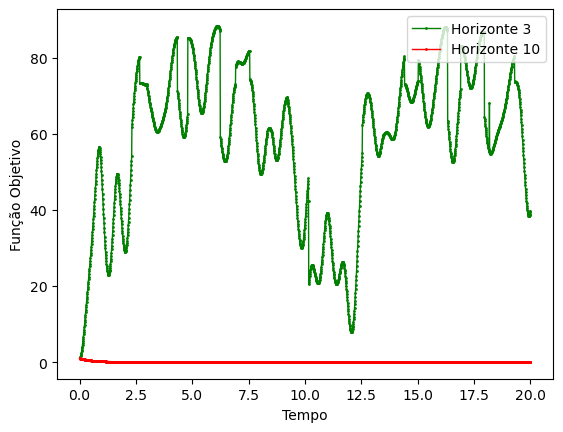

In [5]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Função Objetivo') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(valoresFuncaoObjetivo3[0])/abs(valoresFuncaoObjetivo3[0][0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(valoresFuncaoObjetivo10[0])/abs(valoresFuncaoObjetivo10[0][0]), color='r', marker='o', linewidth=1, markersize=1, label="Horizonte 10")
plt.legend(loc="upper right")
plt.show()

### Avaliação das componentes

Um grande problemas dos métodos de minimização está concentrado no cálculo numérico. O cálculo númerico se trata de um processo de aproximação de forma que quanto pior é a manipulação das variáveis, pior ficará a aproximação. Nesse sistema se torna perceptível a melhoria do ajuste através da desafagem de uma curva em relação a outra.

Conforme o livro, introdução à computação clássica e quântica de Thomas Wong (2022), a defasagem apresentada por um sistema quântico não tem significado físico se for a mesma para todo o sistema, ou seja, todas as componentes devem ter a mesma diferença de fases. Para realizar essa avaliação, se faz necessário propor uma diferença entre a curva original e o destino, tanto na primeira componente quanto na segunda, além de realizar a diferença entre essas partes.

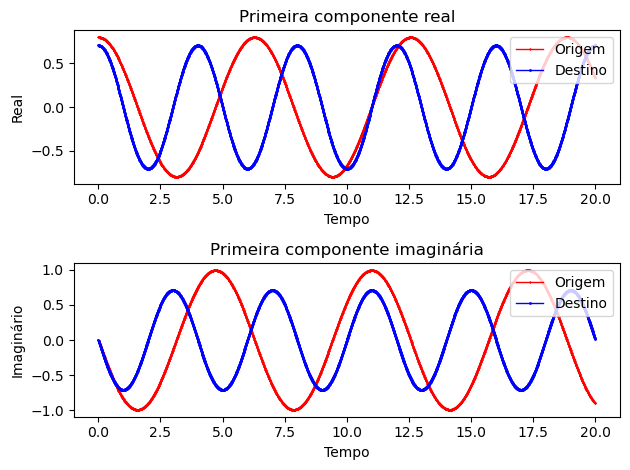

In [6]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda3[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda3[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda3[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda3[1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

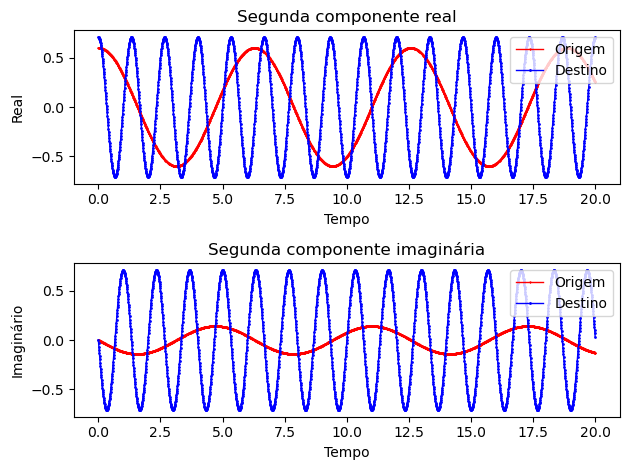

In [7]:
# Plotagem

plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Segunda componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Segunda componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

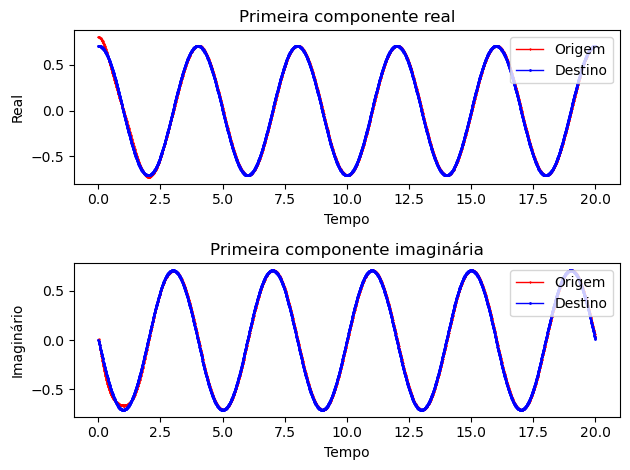

In [8]:
tempo = np.linspace(0, 20, 2000)

realObjetivoPrimeiraComponente = [elemento.real for elemento in valoresOnda10[0]] 
imaginarioObjetivoPrimeiraComponente = [elemento.imag for elemento in valoresOnda10[0]] 

realObjetivoSegundaComponente = [elemento.real for elemento in valoresOnda10[1]] 
imaginarioObjetivoSegundaComponente = [elemento.imag for elemento in valoresOnda10
                                       [1]] 

evolucaoDestino = np.zeros((2,2000), dtype=np.complex_)
for i in range(0, 2000):
    evolucaoDestino[0][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(1/2*np.pi)*i/100))
    evolucaoDestino[1][i] = (1/np.sqrt(2)*np.exp(-1*complex(0,1)*(3/2*np.pi)*i/100))

realDestinoPrimeiraComponente = [elemento.real for elemento in evolucaoDestino[0]] 
imaginarioDestinoPrimeiraComponente = [elemento.imag for elemento in evolucaoDestino[0]] 

realDestinoSegundaComponente = [elemento.real for elemento in evolucaoDestino[1]] 
imaginarioDestinoSegundaComponente = [elemento.imag for elemento in evolucaoDestino[1]] 

# Plotagem
plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoPrimeiraComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoPrimeiraComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

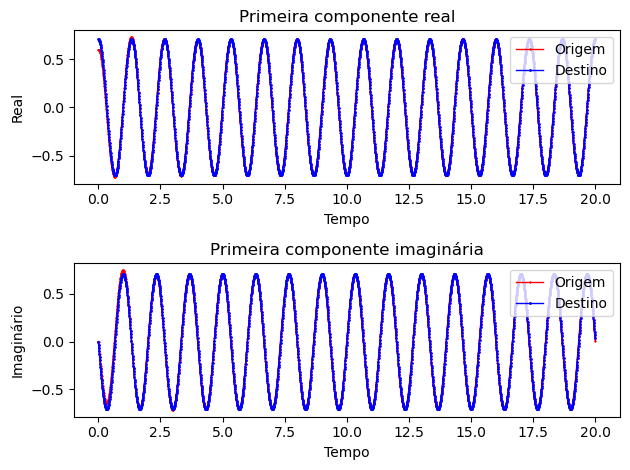

In [9]:
# Plotagem

plt.subplot(2,1,1)

plt.ylabel('Real') 
plt.xlabel('Tempo') 
plt.title('Primeira componente real')
plt.plot(ts, realObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, realDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.subplot(2,1,2)

plt.ylabel('Imaginário') 
plt.xlabel('Tempo') 
plt.title('Primeira componente imaginária')
plt.plot(ts, imaginarioObjetivoSegundaComponente, color='r', marker='*', linewidth=1, markersize=1, label="Origem")
plt.plot(ts, imaginarioDestinoSegundaComponente, color='b', marker='o',  linewidth=1, markersize=1, label="Destino")
plt.legend(loc='upper right')

plt.tight_layout()

### Avaliação do mínimo

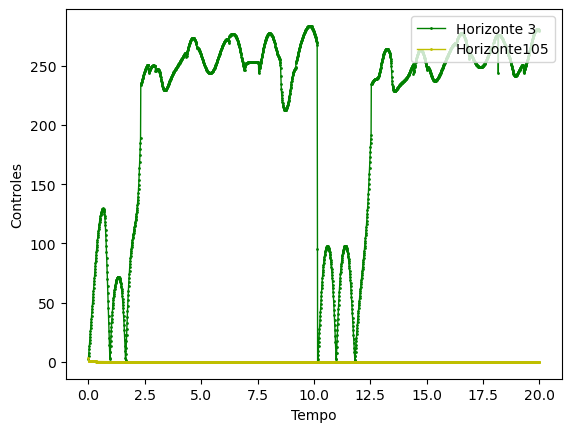

In [10]:
ts = np.linspace(0, 20, 2000) # Tempo em x 

# Plotagem
plt.ylabel('Controles') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(minimos3[0]), color='g', marker='o', linewidth=1, markersize=1, label="Horizonte 3")
plt.plot(ts, abs(minimos10[0]), color='y', marker='o', linewidth=1, markersize=1, label="Horizonte105")
plt.legend(loc="upper right")
plt.show()

### Outra forma de abordar a defasagem

In [11]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda10[0][i]/evolucaoDestino[0][i]))

(1.1313708498984762, 0.0)
(1.1315433680377995, 0.024138058723082313)
(1.1314402209568255, 0.021052996566754155)
(1.1311995356266833, 0.01770506837509608)
(1.1308166749189932, 0.014244860200265006)
(1.1303066771912735, 0.010836616427274943)
(1.1296488106868698, 0.0073543358524979915)
(1.1288721805354247, 0.00395634444072108)
(1.1279804625361187, 0.0006360474702155119)
(1.1269749868319117, -0.002617467220989748)
(1.1258222543703542, -0.005909801155310707)
(1.1245700699639065, -0.009104967846254015)
(1.1232199591927268, -0.012212828555844914)
(1.1217711732708762, -0.015244999919056914)
(1.1201798068583475, -0.018292307018333447)
(1.1185063720390276, -0.021239584682343986)
(1.1167503818454454, -0.024096590669719597)
(1.1149092807887537, -0.026873926879113618)
(1.1129252440971331, -0.02965725499545323)
(1.110877149010085, -0.032335893874300047)
(1.1087624071311226, -0.03491979699923591)
(1.1065770769531351, -0.037418525012514504)
(1.1042628871516749, -0.03989794638640367)
(1.101891367588818

In [12]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda10[1][i]/evolucaoDestino[1][i]))

(0.848528137423857, 0.0)
(0.8482980644980562, 0.04292422981159401)
(0.8484356346974077, 0.037436152652780226)
(0.848756508226955, 0.0314854563215224)
(0.8492665348515474, 0.02534458087101657)
(0.849945183423769, 0.019309157693198173)
(0.8508193484372697, 0.013160228898543175)
(0.8518495166454839, 0.007181153002368043)
(0.8530299379086583, 0.0013625384372566922)
(0.8543578745019537, -0.004312747837755004)
(0.8558763053549774, -0.010025705979996823)
(0.8575209362352674, -0.015537813050217814)
(0.8592886135923805, -0.02086566731147499)
(0.8611790945185545, -0.026028801449632665)
(0.8632480513514024, -0.031179936403462123)
(0.8654152144505296, -0.03612316451699492)
(0.8676799998747324, -0.04087591500731324)
(0.8700444201226957, -0.04545676952087588)
(0.8725808835098435, -0.0500060955946407)
(0.8751868125513719, -0.054342840536391615)
(0.8778644094798768, -0.05848547598172638)
(0.8806174932984512, -0.062451439705624896)
(0.8835176696834521, -0.06634571995816632)
(0.8864735813658111, -0.0700

In [13]:
for i in range(0,2000):
    print(cmath.polar(valoresOnda3[0][i]/evolucaoDestino[0][i]))

(1.1313708498984762, 0.0)
(1.131400900535851, 0.0033338137162939995)
(1.1314910356406662, 0.006668941868319284)
(1.1316412048091373, 0.010006697528799837)
(1.1318513240955534, 0.013348391047661539)
(1.1321212761030066, 0.016695328698660323)
(1.1324509101100904, 0.020048811335602792)
(1.132840042233247, 0.023410133061290674)
(1.133288455624349, 0.0267805799122643)
(1.1337959007030172, 0.030161428562350337)
(1.1343620954230946, 0.03355394504793704)
(1.134986725572611, 0.03695938351780664)
(1.1356694451064882, 0.04037898501024552)
(1.1364098765111728, 0.04381397626003998)
(1.1372076112003007, 0.047265568537834195)
(1.1380622099404374, 0.050734956524194685)
(1.1389732033058677, 0.05422331722057742)
(1.139940092161357, 0.05773180889924436)
(1.1409623481717455, 0.06126157009401828)
(1.1420394143371972, 0.0648137186335978)
(1.1431707055528684, 0.06838935071899159)
(1.1443556091917324, 0.07198954004645595)
(1.1455934857092642, 0.07561533697714688)
(1.146883669268647, 0.0792677677545247)
(1.148

In [14]:
import cmath

for i in range(0,2000):
    print(cmath.polar(valoresOnda3[1][i]/evolucaoDestino[1][i]))

(0.848528137423857, 0.0)
(0.8484880684291546, 0.04476679299480386)
(0.848367866119856, 0.08953314069259197)
(0.8481675445205633, 0.13429859746969333)
(0.8478871270063203, 0.1790627170486342)
(0.8475266463036794, 0.2238250521700051)
(0.847086144492201, 0.26858515426284585)
(0.846565673006401, 0.3133425731130498)
(0.8459652926381531, 0.3580968565292823)
(0.8452850735395634, 0.4028475500059027)
(0.8445250952263345, 0.44759419638237113)
(0.8436854465816378, 0.4923363354986145)
(0.842766225860522, 0.537073503845813)
(0.8417675406948765, 0.5818052342120582)
(0.8406895080989875, 0.6265310553223229)
(0.8395322544757116, 0.6712504914721633)
(0.8382959156233112, 0.7159630621545643)
(0.8369806367429806, 0.7606682816793172)
(0.8355865724471144, 0.8053656587842987)
(0.8341138867683617, 0.850054696238003)
(0.8325627531695146, 0.8947348904326551)
(0.8309333545542843, 0.9394057309672047)
(0.82922588327903, 0.9840667002194781)
(0.827440541165494, 1.0287172729067362)
(0.8255775395146171, 1.0733569156338

### Avaliação das constantes



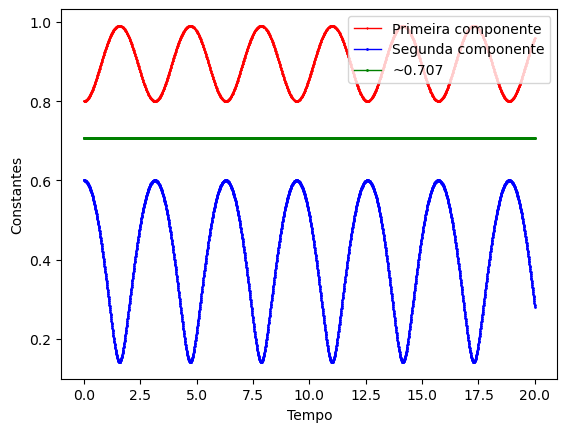

In [15]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes3[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes3[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

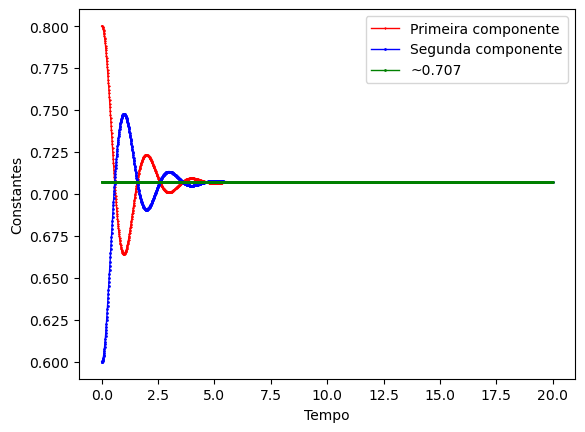

In [16]:
ts = np.linspace(0, 20, 2000) # Tempo em x 
const = []
for i in range(0, 2000):
    const.append(1/np.sqrt(2))

# Plotagem
plt.ylabel('Constantes') 
plt.xlabel('Tempo') 
plt.plot(ts, abs(constantes10[0]), color='r', marker='*', linewidth=1, markersize=1, label="Primeira componente")
plt.plot(ts, abs(constantes10[1]), color='b', marker='o',  linewidth=1, markersize=1, label="Segunda componente")
plt.plot(ts, const, color='g', marker='o',  linewidth=1, markersize=1, label="~0.707")
plt.legend(loc="upper right")
plt.show()

### Gráficos - Avaliação da densidade de probabilidade para encontrar uma partícula no ponto x

Conforme descrito durante os capítulos 1, 2 e 3 do livro Mecânica Quântica por David Griffths, a estatística é um dos principais pontos para o entendimento da mecânica quântica, dessa forma é interessante entender qual é a probabilidade de uma partícula estar em um determinado lugar em um certo tempo e para tal se define:$$\int |\Psi(x,t)|^{2}dx = 1$$ Ainda nessa perspectiva, foi definido que o resultado da equação de Schrödinger pode ser definido a partir da escolha do potêncial V(x,t) e ainda que os enumeros resultados podem formar outros por meio de uma combinação linear de forma que o conjunto do quadrado das constantes que o formam, em sua soma resultam em 1. Isso define a probabilidade de um estado. Para este estudo considerou-se dois estados: $$0.80\psi_0(x,t)+0.60\psi_1(x,t)$$ de forma que para o primeiro estado a probabilidade é de 64% enquanto para o segundo é de 36%.

Se torna claro que a probabilidade total deve ser 1 e definindo o produto interno como $\int |\Psi(x,t)|^{2}dx = <\Psi | \Psi> = 1 = \sum_n |c_n|²$ podemos verificar se o ajuste da pesquisa está correto avaliando as constantes que são alteradas conforme o tempo de acordo com o gráfico apresentado acima.

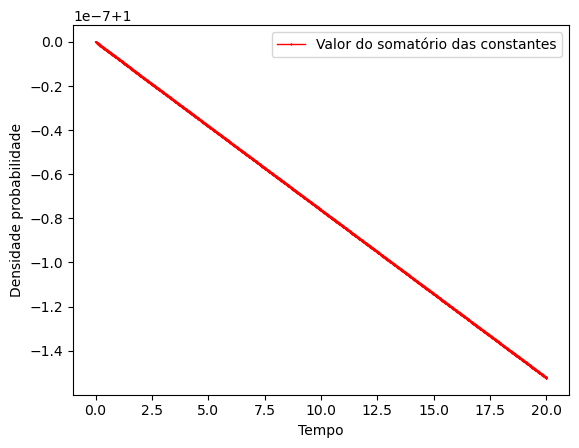

In [17]:
# Plotagem

dp = []
for i in range(0, 2000):
    dp.append((abs(constantes10[0][i])**2+abs(constantes10[1][i])**2))
    
plt.ylabel('Densidade probabilidade') 
plt.xlabel('Tempo') 
plt.plot(ts, dp, color='r', marker='*', linewidth=1, markersize=1, label="Valor do somatório das constantes")
plt.legend(loc="upper right")
#plt.savefig('dp.png', format='png')
plt.show()